In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

## 1.1 Price of Zero-Coupon Bond
 $$ P(t_i, t_m) = P_0*e^{r(t_m-t_i)} $$

## 1.2 Conditions for risk-neutral dynamics
$$ \mathds{E}[St_{i+1}] =  e^{r\Delta t}S_{t_i} $$ $$(Martingale + interest Rate)$$

#### The assumption above and that  d = 1/u leads to conditions for p, u and d:

$$ p = \frac{u*e^{r\Delta t} - 1}{u^2 - 1} $$
$$ 0 < d < e^{r\Delta t} < u < 1 $$

## 1.3 Binomial Tree Method for European Call
$$ Price\ Tree: S_{kn} = S_0 * u^k * d^{n-k} = S_0 * u^{2k-n} $$

#### 1) Value of the option must be equal to the expected payoff at the Maturity:

$$ Payoff:\  P(S) = (S-K)^+ $$

$$ Also\ \mathds{E}[V_{n+1}] = V_n * e^{r/M} $$

#### 2) This leads to formula for Option Value estimation:

$$ V_{kn} =  e^{-r/M} * [pV_{k+1,n+1} + (1-p)V_{k,n+1}] $$

### Firstly, let's visualize the tree and the Payoffs to see that everything is right.

In [4]:
def binomial_method(params, M):
    r = params["Interest Rate"]
    u = params["Up Movement"]
    S0 = params["Initial Price"]
    K = params["Strike"]
    dt = 1 / M

    S_grid = np.zeros((M+1, M+1))
    p = (u * np.exp(r*dt) - 1) / (np.square(u) - 1)

    for n in np.arange(M+1):
        for k in np.arange(n+1):
            S_grid[k,n] = S0 * u ** (2*k - n) # необязательно считать все дерево цены
    Payoff = [max(price - K, 0) for price in S_grid[:, M]]

    V = Payoff
    for i in np.arange(int(M),0,-1):
        for j in range(0,i):
            V[j] = np.exp(-r*dt) * (p*V[j+1] + (1-p)*V[j])
    return S_grid, V[0], Payoff

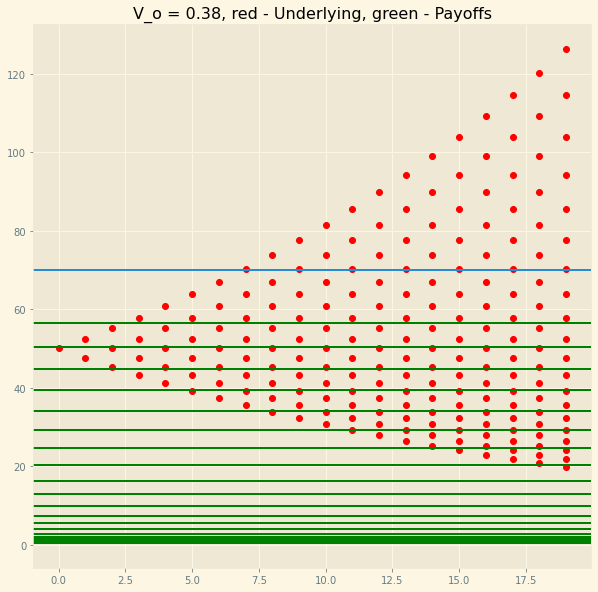

In [5]:
params = {
    "Interest Rate" : 0.01,
    "Up Movement" : 1.05,
    "Initial Price" : 50,
    "Strike" : 70,
}

M = 20
S, V, V_M = binomial_method(params, M)

plt.style.use('Solarize_Light2')
plt.figure(figsize=(10,10))
for n in range(M):
    plt.scatter(n * np.ones(n+1), S[:n+1, n], color = 'red')
    plt.axhline(V_M[n], color = 'green')
plt.title(f'V_o = {round(V,3)}, red - Underlying, green - Payoffs')
plt.axhline(params["Strike"])
plt.show()

## Option price from Number of dots
### This test has not been in assigment, but I'll leave it here just to show that option price does not converges to anything.

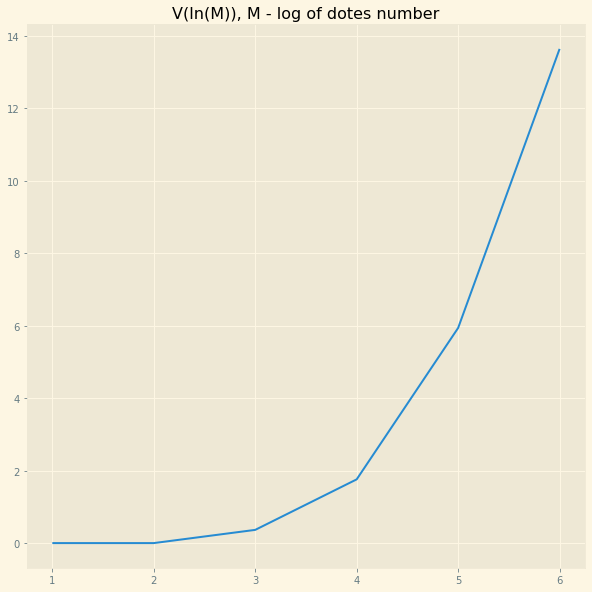

In [6]:
def european_call_option(params, M):
    r = float(params["Interest Rate"])
    u = float(params["Up Movement"])
    S0 = float(params["Initial Price"])
    K = float(params["Strike"])
    dt = 1 / M
    p = (u * np.exp(r*dt) - 1) / (np.square(u) - 1)

    # initialise asset prices at maturity - Time step N
    S_grid = np.zeros(int(M+1))
    S_grid[0] = S0*u**(-M)
    for j in range(1,int(M+1)):
        S_grid[j] = S_grid[j-1]*u**2
    Payoff = [max(price - K, 0) for price in S_grid]

    V = Payoff
    for i in np.arange(int(M),0,-1):
        for j in range(0,i):
            V[j] = np.exp(-r*dt) * ( p*V[j+1] + (1-p)*V[j])
    return V[0]

V_array = list()
dots = 2.718**np.arange(1,7)
for M in dots:
    V = european_call_option(params, M)
    V_array.append(V)

plt.figure(figsize=(10,10))
plt.plot(np.log(dots), V_array)
plt.title("V(ln(M)), M - log of dotes number")
plt.show()

## BSM model and Convergence Rate
#### (In normal case binomial tree method convergences to BSM with rate of 1, but here convergence rate doesn't show anything. However, I've made a formula for it.)

In [7]:
def bsm(params, M):
    r = params["Interest Rate"]
    u = params["Up Movement"]
    S0 = params["Initial Price"]
    K = params["Strike"]
    dt = 1/M
    p = (u * np.exp(r*dt) - 1) / (np.square(u) - 1)
    sigma = S0 * (u - 1/u) * np.sqrt(p * (1 - p))
    D1 = (np.log(S0/K) + sigma**2 / 2) / sigma
    D2 = (np.log(S0/K) - sigma**2 / 2) / sigma
    V = S0*norm.cdf(D1) - K*norm.cdf(D2)
    return V

M = 20
V1 = european_call_option(params, M)
V2 = european_call_option(params, 2*M)
bsm1 = bsm(params, M)

convergence = np.log2(abs(V1-bsm1) / abs(V2-bsm1))
print(V1, V2, bsm1)
print(f" Convergence Rate = {convergence}")

0.37963792425352355 1.3566862582341523 36.91503555566828
 Convergence Rate = 0.03910655652671491


### Now I will try to implement the Binomial Tree Model, that converges to Black-Scholes
### in assumption, that the underlying follows a Geometric Brownian Motion.
### We will use Sigma to recalculate right Up / Down motion and probabilities.

#### Changes to up and down factors according to Seydel:
$$ \beta = [e^{-r*\Delta * t} + e^{(r + \sigma^2)*\Delta * t}]/2 $$
$$ u = \beta + \sqrt{\beta^2 - 1};\ d = 1/u$$

 Convergence Rate = 1.0081154084566029


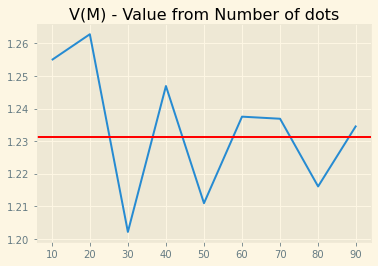

In [8]:
def binomial_to_bsm(params,sigma, M):
    r = params["Interest Rate"]
    S0 = params["Initial Price"]
    K = params["Strike"]
    dt = 1 / M
    # Model from Seydel
    a = (np.exp(-r*dt) + np.exp((r + sigma**2)*dt)) / 2
    u = a + np.sqrt(a**2 - 1)
    p = (u * np.exp(r*dt) - 1) / (np.square(u) - 1)

    # Valuation on tree
    S_grid = np.zeros(int(M+1))
    S_grid[0] = S0*u**(-M)
    for j in range(1,int(M+1)):
        S_grid[j] = S_grid[j-1]*u**2
    Payoff = [max(price - K,0) for price in S_grid]

    V = Payoff
    for i in np.arange(int(M),0,-1):
        for j in range(0,i):
            V[j] = np.exp(-r*dt) * ( p*V[j+1] + (1-p)*V[j])

    V_on_tree = V[0]

    # Valuation by BSM
    D1 = (np.log(S0/K) + r + (sigma**2 / 2)) / sigma
    D2 = (np.log(S0/K) + r - (sigma**2 / 2)) / sigma
    V_bsm = S0*norm.cdf(D1,0,1) - K*np.exp(-r)*norm.cdf(D2,0,1)

    return V_on_tree, V_bsm

M = 20
sigma = 0.3
V1, bsm = binomial_to_bsm(params,sigma, M)
V2, V = binomial_to_bsm(params,sigma, 2*M)

convergence = np.log2(abs(V1-bsm) / abs(V2-bsm))
print(f" Convergence Rate = {convergence}")

V_arr = list()
for M in range (10,100, 10):
    V1, bsm = binomial_to_bsm(params,sigma, M)
    V_arr.append(V1)

plt.plot(range(10, 100, 10), V_arr)
plt.title("V(M) - Value from Number of dots")
plt.axhline(bsm, color = 'red')
plt.show()

## 1.4 Monte-Carlo Delta Hedging
### We will be simulating the underlying as a GBM with drift equal to the interest rate
### Binomial Tree Method is used for calculating Delta-greek with finite differences $$ \Delta = \frac{V(S + dS) - V(S)}{dS} $$
### The idea is to construct the portfolio of Call Option and delta-number of shorted Stocks. On each time step we adjust delta and number of Shares in the portfolio:
$$ Portfolio = (V_c - \Delta * S) $$

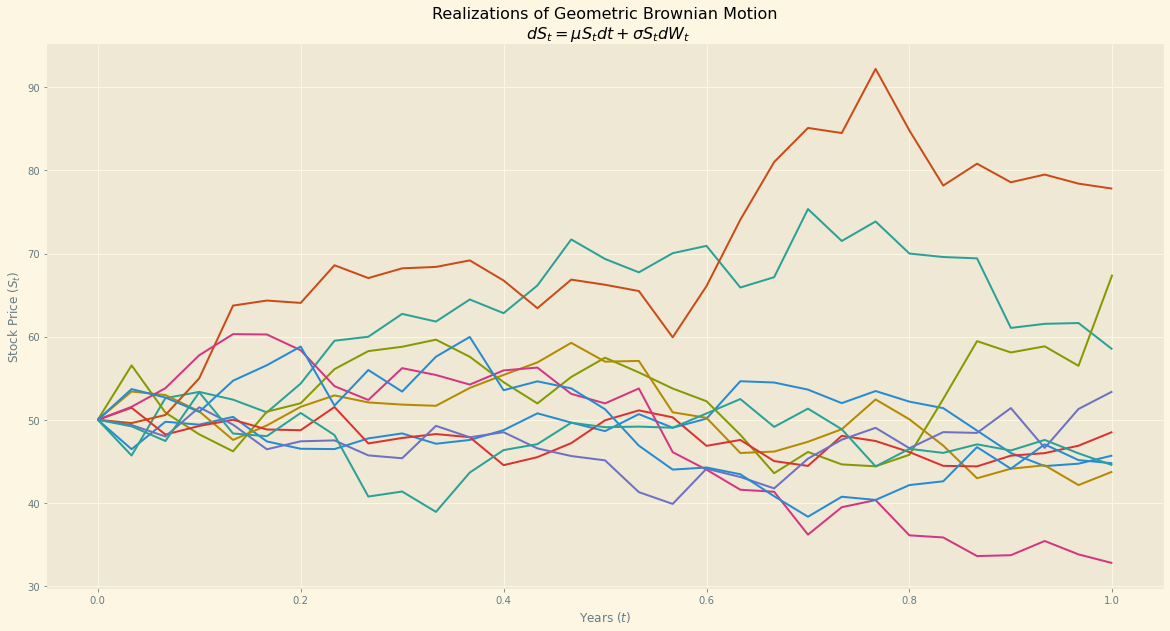

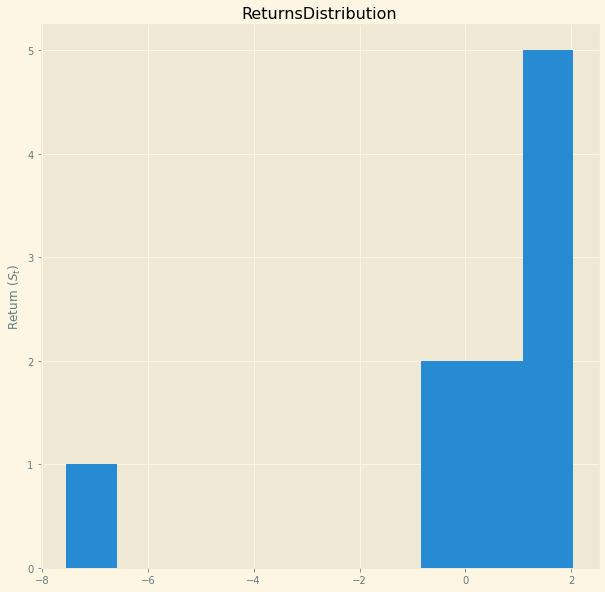

In [11]:
init_params = {
    "Maturity" : 1,
    "Interest_Rate" : 0.01,
    "Sigma" : 0.3,
    "Initial_Price" : 50,
    "Strike" : 70,
    "Nodes_number" : 30,
    "Simulation_number" : 10,
    "Delta_shift" : 0.2,
}

def gbm_Simulation(params):
    mu = params["Interest_Rate"]
    sigma = params['Sigma']
    S0 = params["Initial_Price"]
    K = params["Strike"]
    n = params["Nodes_number"]
    Sim_number = params['Simulation_number']
    T = 1
    dt = T/n

    St = np.exp((mu - sigma ** 2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size=(Sim_number,n)).T)
    St = np.vstack([np.ones(Sim_number), St])
    St = S0 * St.cumprod(axis=0)
    time = np.linspace(0,T,n+1)
    tt = np.full(shape=(Sim_number,n+1), fill_value=time).T
    return tt, St, time

def binomial(params):
    dt = params['Maturity'] / params['Nodes_number']
    a = (np.exp(-params['Interest_Rate']*dt) + np.exp((params['Interest_Rate'] + sigma**2)*dt)) / 2
    u = a + np.sqrt(a**2 - 1)
    p = (u * np.exp(params['Interest_Rate']*dt) - 1) / (np.square(u) - 1)

    S_grid = np.zeros(int(params['Nodes_number']+1))
    S_grid[0] = params['Initial_Price']*u**(-params['Nodes_number'])
    for j in range(1,int(params['Nodes_number']+1)):
        S_grid[j] = S_grid[j-1]*u**2
    Payoff = [max(price - params['Strike'],0) for price in S_grid]

    V = Payoff
    for i in np.arange(int(params['Nodes_number']),0,-1):
        for j in range(0,i):
            V[j] = np.exp(-params['Interest_Rate']*dt) * ( p*V[j+1] + (1-p)*V[j])
    return V[0]

def getDelta(params):
    V = binomial(params)
    params['Initial_Price'] += params['Delta_shift']
    V_shift = binomial(params)
    return (V_shift - V) / params['Delta_shift']

def getReturn(params, init_params, S_array, t_array):
    V0 = binomial(params)
    OptionReturn = max(0, S_array[-1] - params['Strike']) - V0
    delta_array = list()
    for i in range(len(t_array)-1):
        params['Initial_Price'] = S_array[i]
        params['Maturity'] = 1 - t_array[i]
        params['Nodes_number'] = len(t_array) - i
        delta = getDelta(params)
        delta_array.append(delta)
        params = init_params
    HedgingReturn = 0
    for i in range(len(delta_array)-1):
        ret = delta_array[i] * (S_array[i] - S_array[i+1])
        HedgingReturn += ret
    return OptionReturn + HedgingReturn

params = init_params
tt, St, t_array = gbm_Simulation(params)
Returns_stats = list()
for j in range(params['Simulation_number']):
    S_array = list()
    for i in range(len(t_array)-1):
        s = St[i][j]
        S_array.append(s)
    difference = getReturn(params, init_params, S_array, t_array)
    params = init_params
    Returns_stats.append(difference)

plt.figure(figsize=(20,10))
plt.plot(tt, St)
plt.xlabel("Years $(t)$")
plt.ylabel("Stock Price $(S_t)$")
plt.title(
    "Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$")
plt.show()

plt.figure(figsize=(10,10))
plt.hist(Returns_stats)
plt.ylabel("Return $(S_t)$")
plt.title("ReturnsDistribution")
plt.show()

### We see that there are some unexpected big losses in cases of rapid movement of price. Lets See, how well we replicate the underlying By plotting the Standard Deviation of returns from Number of Nodes in modeling

In [ ]:
init_params = {
    "Maturity" : 1,
    "Interest_Rate" : 0.01,
    "Sigma" : 0.3,
    "Initial_Price" : 50,
    "Strike" : 70,
    "Nodes_number" : 30,
    "Simulation_number" : 50,
    "Delta_shift" : 1,
}

STD_array = list()

for NUM in (5, 10, 20, 40, 80):
    init_params['Nodes_number'] = NUM
    params = init_params
    tt, St, t_array = gbm_Simulation(params)
    Returns_stats = list()
    for j in range(params['Simulation_number']):
        S_array = list()
        for i in range(len(t_array)-1):
            s = St[i][j]
            S_array.append(s)
        difference = getReturn(params, init_params, S_array, t_array)
        params = init_params
        Returns_stats.append(difference)
    STD = np.std(Returns_stats)
    STD_array.append(STD)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot((5, 10, 20, 40, 80), STD_array)
plt.ylabel("Return $(S_t)$")
plt.title("ReturnsDistribution")
plt.show()

## 1.5 American Put Option

In [ ]:
def american_put_option(params, M):
    r = params["Interest Rate"]
    u = params["Up Movement"]
    S0 = params["Initial Price"]
    K = params["Strike"]
    dt = 1 / M
    p = (u * np.exp(r*dt) - 1) / (np.square(u) - 1)

    S_grid = np.zeros((M, M)) # calculate Underlying price
    for n in np.arange(M):
        for k in np.arange(n+1):
            S_grid[k,n] = S0 * u ** (2*k - n)

    V = S_grid.copy()
    for k in np.arange(M): # Payoff at Maturity
        if S_grid[k,M-1] < K:
            V[k,M-1] = K - S_grid[k,M-1]
        else:
            V[k,M-1] = 0

    for n in np.arange(M-2, -1, -1): # Reverse calculating of Option Value
        for k in np.arange(n+1):
            V[k,n] = max(K - S_grid[k,n], np.exp(-r*dt) * (p*V[k+1,n+1] + (1-p) * V[k,n+1]))
    return V

params = {
    "Interest Rate" : 0.01,
    "Up Movement" : 1.05,
    "Initial Price" : 50,
    "Strike" : 35,
}

M = 30

V = american_put_option(params, M)

plt.figure(figsize=(10,10))
for n in range(M):
            plt.scatter(n * np.ones(n+1), V[:n+1, n], color = 'red')
plt.title(f'V_o = {round(V[0,0],3)}')
plt.show()